<a href="https://colab.research.google.com/github/SonakshiA/Citrus-Leaves-Classification/blob/main/Citrus_Fruit_Disease_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing the Required Libraries**

In [2]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, datasets
import tensorflow_datasets as tfds

**Citation**

@article{rauf2019citrus,
  title={A citrus fruits and leaves dataset for detection and classification of
citrus diseases through machine learning},
  author={Rauf, Hafiz Tayyab and Saleem, Basharat Ali and Lali, M Ikram Ullah
and Khan, Muhammad Attique and Sharif, Muhammad and Bukhari, Syed Ahmad Chan},
  journal={Data in brief},
  volume={26},
  pages={104340},
  year={2019},
  publisher={Elsevier}
}

**Loading the dataset**

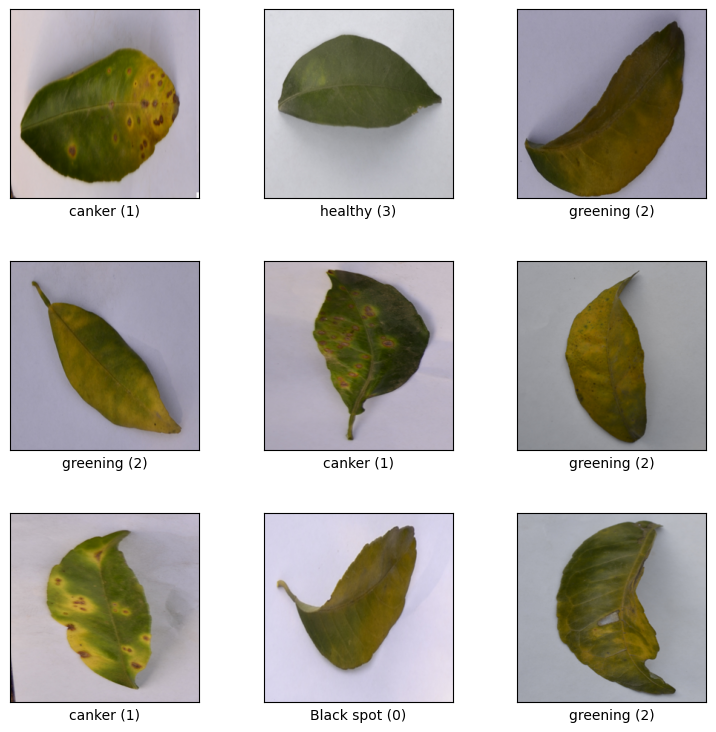

In [3]:
ds, ds_info = tfds.load('citrus_leaves',with_info=True, shuffle_files = True, as_supervised = True)
train_ds = ds['train']
fig = tfds.show_examples(train_ds,ds_info)
print(train_ds)

In [4]:
for image_batch, lables_batch in train_ds.take(1):
  print(image_batch.shape)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
(256, 256, 3)


**Resizing the Images to 28x28 and labelling them as True or False based on their label**

Labels 1 and 2 are unhealthy, label 3 is healthy

In [5]:
HEALTHY_LEAF_CLASS = True #The above images show that healthy leaves have label 3
MAX_SIDE_LEN = 128
train_ds = train_ds.map(
    lambda image, label: (tf.cast(tf.image.resize(image,[MAX_SIDE_LEN,MAX_SIDE_LEN]),dtype=tf.int32),label == HEALTHY_LEAF_CLASS)
)

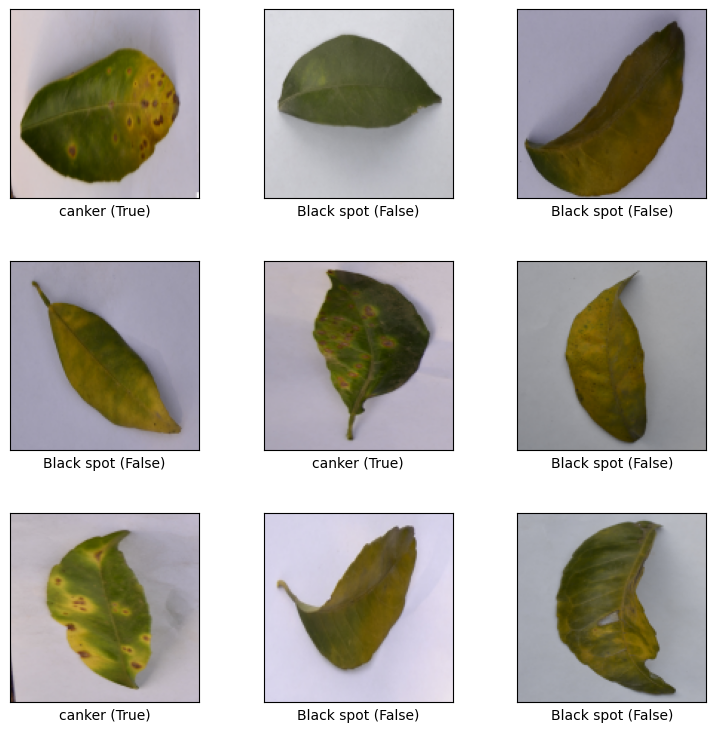

In [6]:
fig = tfds.show_examples(train_ds,ds_info)

Since our dataset is small, we have to repeat the images to increase dataset size

In [7]:
train_healthy = train_ds.filter(lambda image, label: label==True).repeat(5) #repeat to get more healthy leaves in a new dataset for better training
train_nothealthy = train_ds.filter(lambda image, label: label==False).repeat(2)

In [8]:
batch_size = 16
train_ds = tf.data.Dataset.sample_from_datasets([train_healthy,train_nothealthy],weights=[0.5,0.5],stop_on_empty_dataset=True)
train_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.bool, name=None))>

**Augmenting the Dataset to prevent overfitting**

In [9]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'), #flipping images horizontally
    tf.keras.layers.RandomRotation(0.2) #Rotating the images
])

In [10]:
for i,_ in ds['train'].take(1):
  image = i

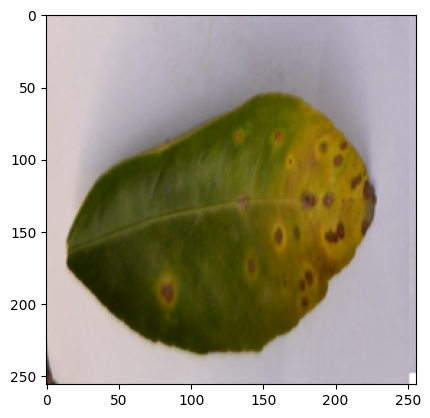

In [11]:
plt.imshow(image)

In [12]:
image = tf.cast(tf.expand_dims(image,0),tf.float32)
image/=255.0

In [13]:
image.shape

TensorShape([1, 256, 256, 3])

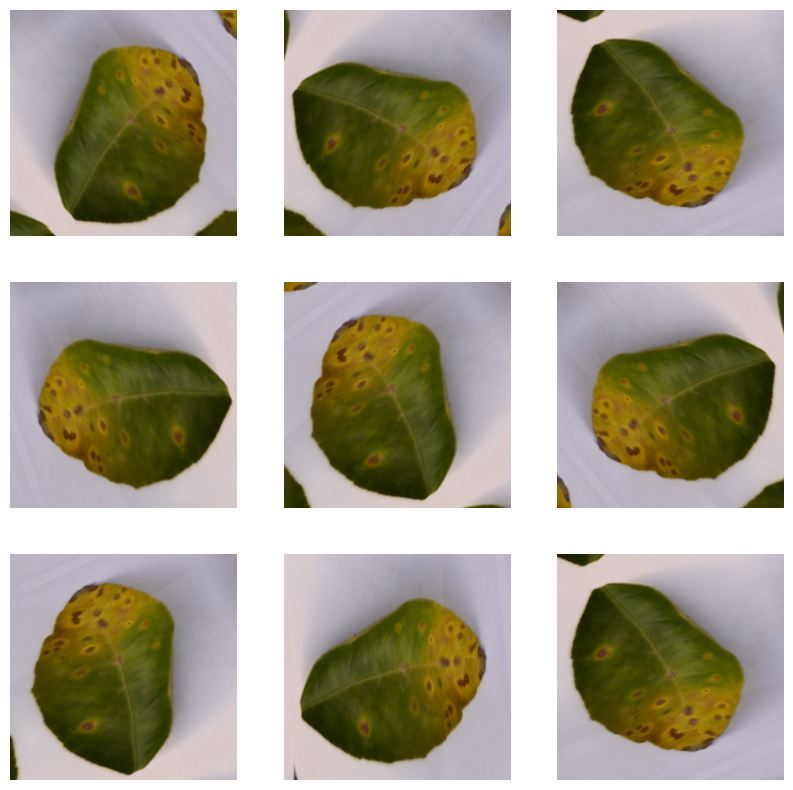

In [14]:
plt.figure(figsize=(10,10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3,3,i+1)
  plt.imshow(augmented_image[0])
  plt.axis('off')

**Increasing Dimensionality of the Images**

In [15]:
def add_dimension(img,lbl):
  image, label = img,lbl
  return tf.expand_dims(image,axis=0),tf.expand_dims(label,axis=0)


train_ds_4d = train_ds.map(add_dimension)

In [16]:
for img,label in train_ds_4d.take(5):
  print(img.shape)
  print(label.shape)

(1, 128, 128, 3)
(1,)
(1, 128, 128, 3)
(1,)
(1, 128, 128, 3)
(1,)
(1, 128, 128, 3)
(1,)
(1, 128, 128, 3)
(1,)


In [30]:
model = models.Sequential()
model.add(layers.Rescaling(1./255)) #getting results between 0 and 1 instead of 0 to 255 for all the colors
model.add(data_augmentation)
model.add(layers.Conv2D(64,(3,3),activation='relu',input_shape=(128,128,3)))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Dropout(0.5))
model.add(layers.Conv2D(64,(3,3),activation='relu',kernel_regularizer = tf.keras.regularizers.l2(l=0.01)))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Dropout(0.5))
model.add(layers.Conv2D(64,(3,3),activation='relu',kernel_regularizer = tf.keras.regularizers.l2(l=0.01)))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dense(2))

In [32]:
model.compile(optimizer = tf.keras.optimizers.Adam(0.01),loss=tf.keras.losses.BinaryCrossentropy(),metrics=['accuracy'])

In [33]:
model.fit(train_ds_4d, epochs=5, batch_size=16)

Epoch 1/5
1656/1656 [==============================] - 109s 65ms/step - loss: 7.6232 - accuracy: 0.5072
Epoch 2/5
1656/1656 [==============================] - 105s 64ms/step - loss: 7.5913 - accuracy: 0.5079
Epoch 3/5
1656/1656 [==============================] - 105s 63ms/step - loss: 7.5913 - accuracy: 0.5079
Epoch 4/5
1656/1656 [==============================] - 106s 64ms/step - loss: 7.5913 - accuracy: 0.5079
Epoch 5/5
1656/1656 [==============================] - 106s 64ms/step - loss: 7.5913 - accuracy: 0.5079
